In [41]:
import numpy as np
import cv2
import sys
from random import randint
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
video_source = 'Cars.mp4'
video_output = 'Cars_temporal_median_filter.mp4'

In [5]:
cap = cv2.VideoCapture(video_source)
has_frame, frame = cap.read()
print(has_frame,frame.shape)

True (720, 1280, 3)


In [4]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter(video_output,fourcc,25,(frame.shape[1],frame.shape[0]),False)
print(cap.get(cv2.CAP_PROP_FRAME_COUNT))

3000.0


In [5]:
frame_ids = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=25)

In [ ]:
len(frame_ids)

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES,1262)
has_frame, frame = cap.read()
cv2.imshow('Test',frame)
cv2.waitKey(0)


In [ ]:
frames = []
for fid in frame_ids:
    cap.set(cv2.CAP_PROP_POS_FRAMES,fid)
    has_frame,frame = cap.read()
    frames.append(frame)

In [ ]:
print(np.asarray(frames).shape)

In [ ]:
for frame in frames:
    cv2.imshow('Frame',frame)
    cv2.waitKey(0)


In [ ]:
median_frame = np.median(frames,axis=0).astype(dtype=np.uint8)

In [ ]:
cv2.imshow('Frame',median_frame)
cv2.waitKey(0)

In [ ]:
cv2.imwrite('model_median_frame.jpg',median_frame)

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES,0)
gray_median_frame = cv2.cvtColor(median_frame,cv2.COLOR_BGR2GRAY)
cv2.imshow('Frame',gray_median_frame)
cv2.waitKey(0)

In [ ]:
while (True):
    has_frame, frame = cap.read()
    
    if not has_frame:
        print('end of video')
        break
        
    frame_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    dframe = cv2.absdiff(frame_gray,gray_median_frame)
    
    th,dframe = cv2.threshold(dframe, 0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    writer.write(dframe)
        
    cv2.imshow('Frame',dframe)
    if cv2.waitKey(1) and 0xff ==ord('q'):
        break
    
writer.release()
cap.release()


OTHER ALGORITHMS

Preprocessing

In [6]:
text_color = (randint(0,255),randint(0,255),randint(0,255))
border_color = (randint(0,255),randint(0,255),randint(0,255))
bgs_types = ['GMG','MOG2','MOG','KNN','CNT']

In [7]:
def get_kernel(kernel_type):
    
    if kernel_type == 'dilation':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    if kernel_type =='opening':
        kernel = np.ones((3,3),np.uint8)
    if kernel_type =='closing':
        kernel = np.ones((3,3),np.uint8)
    return kernel

In [8]:
def get_filters(img,img_filter):
    if img_filter == 'closing':
        return cv2.morphologyEx(img,cv2.MORPH_CLOSE,get_kernel('closing'),iterations=2)
    if img_filter == 'opening':
        return cv2.morphologyEx(img,cv2.MORPH_OPEN,get_kernel('opening'),iterations=2)
    if img_filter == 'dilation':
        return cv2.dilate(img,get_kernel('dilation'),iterations=2)
    if img_filter == 'combine':
        closing = cv2.morphologyEx(img,cv2.MORPH_CLOSE,get_kernel('closing'),iterations=2)
        opening = cv2.morphologyEx(closing,cv2.MORPH_OPEN,get_kernel('opening'),iterations=2)
        dilation = cv2.dilate(img,get_kernel('dilation'),iterations=2)
        return dilation

In [9]:
def get_bgsubtractor(bgs_type):
    if bgs_type =='GMG':
        return cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames = 120, decisionThreshold = 0.8)
    if bgs_type =='MOG':
        return cv2.bgsegm.createBackgroundSubtractorMOG(history = 200, nmixtures = 5,backgroundRatio = 0.7, noiseSigma=0)        
    if bgs_type =='MOG2':
        return cv2.createBackgroundSubtractorMOG2(history = 500, varThreshold = 16,detectShadows = False)
    if bgs_type =='KNN':
        return cv2.createBackgroundSubtractorKNN(history = 500, dist2Threshold = 400,detectShadows = False)        
    if bgs_type =='CNT':
        return cv2.bgsegm.createBackgroundSubtractorCNT(minPixelStability = 15,useHistory = True, maxPixelStability = 15*60,
                                                       isParallel = True)
    print('Invalid Detetctor')
    sys.exit(0)
        


In [10]:
cap = cv2.VideoCapture('Cars.mp4')
bg_subtractor = get_bgsubtractor(bgs_types[0])
bgs_type = bgs_types[0]
bgs_type

'GMG'

In [11]:
def main():
    while cap.isOpened():
        ok,frame = cap.read()
        print('ok')
        frame = cv2.resize(frame,(0,0),fx = 0.5, fy =0.5)
        
        if not ok:
            print('end video')
            break
            
        bg_mask = bg_subtractor.apply(frame)
        fg_mask = get_filters(bg_mask,'dilation')
        fg_mask_opening = get_filters(bg_mask,'opening')
        fg_mask_closing = get_filters(bg_mask,'closing')
        fg_mask_combine = get_filters(bg_mask,'combine')
        
        res = cv2.bitwise_and(frame,frame,mask=fg_mask)
        res_opening = cv2.bitwise_and(frame,frame,mask=fg_mask_opening)
        res_closing = cv2.bitwise_and(frame,frame,mask=fg_mask_closing)
        res_combine = cv2.bitwise_and(frame,frame,mask=fg_mask_combine)
        
        if bgs_type!='MOD' and bgs_type != 'GMG':
            cv2.imshow('background image',bg_subtractor.getBackgroundImage())
            
        cv2.imshow('Frame',frame)
#         cv2.imshow('bg mask',bg_mask)
#         cv2.imshow('fg mask',fg_mask)
        cv2.imshow('res',res)
        cv2.imshow('res_open',res_opening)
        cv2.imshow('res_close',res_closing)
        cv2.imshow('res_combine',res_combine)
        
        if cv2.waitKey(1) and 0xff ==ord('q'):
            break

In [108]:
main()

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

KeyboardInterrupt: 

Quality Comparison

In [12]:
cap = cv2.VideoCapture('Cars.mp4')
bg_subtractor = get_bgsubtractor(bgs_types[0])
bgs_type = bgs_types[0]
bgs_type

'GMG'

In [13]:
def get_bgsubtractor(bgs_type):
    if bgs_type =='GMG':
        return cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames = 120, decisionThreshold = 0.8)
    if bgs_type =='MOG':
        return cv2.bgsegm.createBackgroundSubtractorMOG(history = 200, nmixtures = 5,backgroundRatio = 0.7, noiseSigma=0)        
    if bgs_type =='MOG2':
        return cv2.createBackgroundSubtractorMOG2(history = 500, varThreshold = 16,detectShadows = False)
    if bgs_type =='KNN':
        return cv2.createBackgroundSubtractorKNN(history = 500, dist2Threshold = 400,detectShadows = False)        
    if bgs_type =='CNT':
        return cv2.bgsegm.createBackgroundSubtractorCNT(minPixelStability = 15,useHistory = True, maxPixelStability = 15*60,
                                                       isParallel = True)
    print('Invalid Detetctor')
    sys.exit(0)
        


In [14]:
bg_sub = []

for i , a in enumerate(bgs_types):
    print(i,a)
    bg_sub.append(get_bgsubtractor(a))
    
bg_sub

0 GMG
1 MOG2
2 MOG
3 KNN
4 CNT


[< cv2.bgsegm.BackgroundSubtractorGMG 0000029F84061F30>,
 < cv2.BackgroundSubtractorMOG2 0000029F84061FB0>,
 < cv2.bgsegm.BackgroundSubtractorMOG 0000029F84061D10>,
 < cv2.BackgroundSubtractorKNN 0000029F840A32D0>,
 < cv2.bgsegm.BackgroundSubtractorCNT 0000029F840A3150>]

In [26]:
fp = open('report.csv',mode='w')
writer = csv.DictWriter(fp,fieldnames=['frame','pixel count'])

In [29]:
def main():
    framecount = 0
    while cap.isOpened():
        ok,frame = cap.read()
        print('ok')
        framecount += 1
        frame = cv2.resize(frame,(0,0),fx = 0.5, fy =0.5)
        
        if not ok:
            print('end video')
            break
            
        gmg = bg_sub[0].apply(frame)
        mod2 = bg_sub[1].apply(frame)
        mod = bg_sub[2].apply(frame)
        knn = bg_sub[3].apply(frame)
        cnt = bg_sub[4].apply(frame)
        
        gmg_count = np.count_nonzero(gmg)
        mod2_count = np.count_nonzero(mod2)
        mod_count = np.count_nonzero(mod)
        knn_count = np.count_nonzero(knn)
        cnt_count = np.count_nonzero(cnt)
        
        writer.writerow({'frame':'GMG','pixel count':gmg_count})
        writer.writerow({'frame':'MOD2','pixel count':mod2_count})
        writer.writerow({'frame':'MOD','pixel count':mod_count})
        writer.writerow({'frame':'KNN','pixel count':knn_count})
        writer.writerow({'frame':'CNT','pixel count':cnt_count})
        
        cv2.imshow('original',frame)
        cv2.imshow('GMG',gmg)
        cv2.imshow('MOD2',mod2)
        cv2.imshow('MOD',mod)
        cv2.imshow('KNN',knn)
        cv2.imshow('CNT',cnt)
        
        
        k = cv2.waitKey(1) and 0xff
        if k==27:
            break

In [30]:
main()

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
o

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


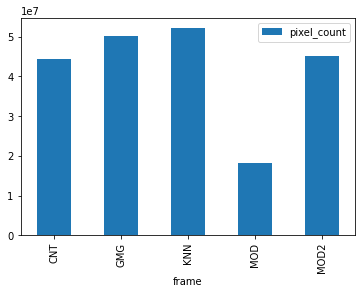

In [42]:
evaluation = pd.read_csv('report.csv',header=None)
evaluation = evaluation.rename(columns={0:'frame',1:'pixel_count'})
eval_results = evaluation.groupby(['frame']).sum()
eval_results.plot.bar()
plt.show()